<a href="https://colab.research.google.com/github/ehpub/KFQ_DL_2023-/blob/main/2023_kfq_%EB%94%A5%EB%9F%AC%EB%8B%9D_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


참고 교재: https://www.gilbut.co.kr/book/view?bookcode=BN003496

In [1]:
!mkdir 'celeba_gan'
!wget "https://drive.google.com/uc?id=1up5bN8LCE2vHigVY-Z9yY2_aKRW5jN_9&confirm=t" -O celeba_gan/data.zip

--2023-07-27 02:11:22--  https://drive.google.com/uc?id=1up5bN8LCE2vHigVY-Z9yY2_aKRW5jN_9&confirm=t
Resolving drive.google.com (drive.google.com)... 142.250.145.101, 142.250.145.138, 142.250.145.139, ...
Connecting to drive.google.com (drive.google.com)|142.250.145.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/k4fci24aj6a6mn17lfo4d8na1pgoc8u4/1690423875000/10613826186492816817/*/1up5bN8LCE2vHigVY-Z9yY2_aKRW5jN_9?uuid=2fdd489a-3c0e-46df-9424-0586748144d6 [following]
--2023-07-27 02:11:22--  https://doc-04-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/k4fci24aj6a6mn17lfo4d8na1pgoc8u4/1690423875000/10613826186492816817/*/1up5bN8LCE2vHigVY-Z9yY2_aKRW5jN_9?uuid=2fdd489a-3c0e-46df-9424-0586748144d6
Resolving doc-04-a4-docs.googleusercontent.com (doc-04-a4-docs.googleusercontent.com)... 108.177.127.132, 2a00:1450:4013:c07::84
Conne

In [2]:
!unzip -qq celeba_gan/data.zip -d celeba_gan

In [3]:
from tensorflow import keras

In [33]:
dataset = keras.utils.image_dataset_from_directory(
    "celeba_gan/img_align_celeba",
    label_mode=None,
    image_size=(184, 224),
    batch_size=32,
    smart_resize=True)

Found 202599 files belonging to 1 classes.


In [34]:
import matplotlib.pyplot as plt

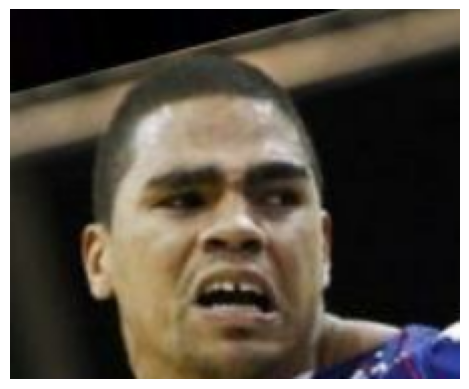

In [35]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy()).astype("int32")[0])
    break

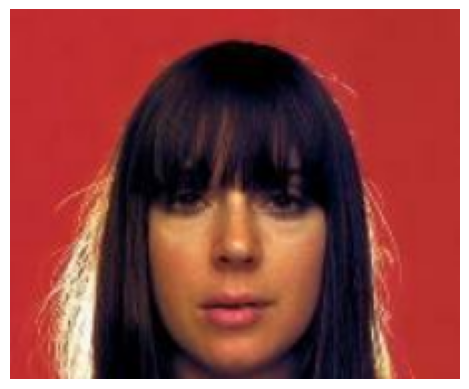

In [36]:
dataset = dataset.map(lambda x: x / 255.)
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [9]:
from tensorflow.keras import layers

In [37]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(184, 224, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

In [38]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 92, 112, 64)       3136      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 92, 112, 64)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 46, 56, 128)       131200    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 46, 56, 128)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 23, 28, 128)       262272    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 23, 28, 128)       0         
                                                                 
 flatten_2 (Flatten)         (None, 82432)           

In [39]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(23 * 28 * 128),
        layers.Reshape((23, 28, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [40]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 82432)             10633728  
                                                                 
 reshape_2 (Reshape)         (None, 23, 28, 128)       0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 46, 56, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 46, 56, 128)       0         
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 92, 112, 256)     524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 92, 112, 256)      0 

In [41]:
import tensorflow as tf

In [42]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        )
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

In [43]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")
            plt.imshow(img)
            plt.show()

In [ ]:
epochs = 100

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=5, latent_dim=latent_dim)]
)

Epoch 1/100
3574/6332 [===============>..............] - ETA: 2:02:04 - d_loss: -250.0433 - g_loss: 841927.3125